# COGS 118A - Final Project

# Enhancing Confidence in Electric Vehicle Road Trips Through Charging Station Availability Prediction

## Group members


- Kendrick Nguyen
- Mason Pak
- Noel Garcia

# Abstract 

In this day and age, electric vehicles (EVs) are taking over the streets due to its outweighing benefits in being environmentally friendly, efficient, and gas-free. However, a significant barrier that is preventing most households from switching to EVs is the convenience of charging stations. Thus, for our project we would like to create a model that predicts the general availability of charging stations and specific availabilities given variables, such as starting location, charger types, public access, and EV charging brands and connectors, to reassure the difficulties in road trip planning with EVs. 

Specific datasets we would employ for our model would be geographic and technical datasets of charging stations in the United States. All charging station observations will be trained using a DSCAN classification algorithm. Our project will employ a custom metric for measuring the availability of stations, represented as the average single road-trip distance (with no stops) a driver coudl last within a safe range of charging stations. This "safe range" will be determined by a hyperparameter from model selection.

# Background

With the explosive market growth for EVs and charging system’s development, driving electric has become a popular trend. However, a huge leap that prevents everyone from buying an EV would be its arised difficulties, specifically vehicle mileage restrictions, charging station density distribution between suburbs and cities, and battery capacity<a name="garling"></a>[<sup>[1]</sup>](#garlingnote). Due to these issues, most households may prefer owning a gas vehicle for contemporary use. 

Relevant studies have addressed these difficulties by predicting the availability and preferability of charging stations. For instance, a study by Aguilar-Dominguez conducted on transport data taken from the UK’s National Travel Survey classified observations on vehicle usage and number of feasible trips using regression and geospatial clustering<a name="dominguez"></a>[<sup>[2]</sup>](#domingueznote). The model was able to predict the optimal charging–discharging schedule and electricity bills based on occupancy, location, and vehicle specifications. Another study examined the charging behaviors between various charging stations (specifically factors that makes certain stations better than others) using historical data spanning three years of 100,000 charging sessions<a name="ullah"></a>[<sup>[3]</sup>](#ullah). Factors, such as enroute charging (fast charging), after-trip charging (normal charging), facilities, charging cost, and performance of the battery, were revealed as the most important factors when evaluating an XGBoost model.

# Problem Statement

In the scope of this project, we would like to predict the general availability of vehicle charging stations and specific availabilities from variables, such as starting location, charger types, public access, and EV charging brands and connectors. 

The problem is quantifiable and measurable in the sense of classifying a given test location and measuring the Haversine distance between the point and its respective DBSCAN cluster's station/center point. The problem presents a performance metric (or distance metric) for a given location based on the average single road-trip distance (with no stops) a driver could last within a safe range of charging stations. This problem is replicable so long as EVs remain relevant.

### EV Charger Types

![ports](images/ev_types.png)

### EV Port Types

![ports](images/ev_ports.png)

# Data

### Setup

Import the following packages, set global settings

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from geopy.distance import distance
from shapely.geometry import MultiPoint

import random

# Save model selection performances
import pickle

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

sns.set(style='white', rc={'lines.linewidth': '0.3'})

# Set to `True` if you would like to do a new model selection. Otherwise, you can pickle the previous model selection
# Takes approximately ~10 minutes to perform model selection
NEW_MODEL_SELECTION = False

### Dataset: Electric & Alternative Fuel Charging Stations 2023
- Link: https://www.kaggle.com/datasets/saketpradhan/electric-and-alternative-fuel-charging-stations or, alternatively, https://afdc.energy.gov/stations/#/find/nearest
- Number of observations: 65 variables, 70406 observations
- Description: An observation consist of a vehicle class, station name, location details, schedules, EV-connector types, etc. Some critical variables would be location details (specifically represented as latitude and longitude values), charger types, and EV-connector types. The dataset appears to have numerous null entries, requiring cleaning.

In [2]:
stations_df = pd.read_csv('data/Electric and Alternative Fuel Charging Stations.csv', low_memory=False)

stations_df.head()

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
0,CNG,Spire - Montgomery Operations Center,2951 Chestnut St,NaN,Montgomery,AL,36107,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,MD,NaN,NaN,NaN
1,CNG,PS Energy - Atlanta,340 Whitehall St,"From I-7585 N, exit 91 to Central Ave, left on...",Atlanta,GA,30303,NaN,770-350-3000,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False
2,CNG,Metropolitan Atlanta Rapid Transit Authority,2424 Piedmont Rd NE,NaN,Atlanta,GA,30324,NaN,NaN,E,...,NaN,NaN,NaN,NaN,Q,3000,LD,NaN,NaN,NaN
3,CNG,United Parcel Service,270 Marvin Miller Dr,NaN,Atlanta,GA,30336,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,HD,NaN,NaN,NaN
4,CNG,Arkansas Oklahoma Gas Corp,2100 S Waldron Rd,NaN,Fort Smith,AR,72903,NaN,479-783-3188,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False


### Cleaning of Electric & Alternative Fuel Charging Stations 2023 Dataset

In [3]:
# Show raw columns
stations_df.columns

Index(['Fuel Type Code', 'Station Name', 'Street Address',
       'Intersection Directions', 'City', 'State', 'ZIP', 'Plus4',
       'Station Phone', 'Status Code', 'Expected Date',
       'Groups With Access Code', 'Access Days Time', 'Cards Accepted',
       'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network',
       'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude',
       'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code',
       'Federal Agency ID', 'Federal Agency Name', 'Open Date',
       'Hydrogen Status Link', 'NG Vehicle Class', 'LPG Primary',
       'E85 Blender Pump', 'EV Connector Types', 'Country',
       'Intersection Directions (French)', 'Access Days Time (French)',
       'BD Blends (French)', 'Groups With Access Code (French)',
       'Hydrogen Is Retail', 'Access Code', 'Access Detail Code',
       'Federal Agency Code', 'Facility Type', 'CNG Dispenser N

In [4]:
# Standardize to US stations
stations_df = stations_df[stations_df['Country'] == 'US']

# Select columns of interest
stations_df = stations_df[['Station Name',
                           'Street Address',
                           'City',
                           'State',
                           'ZIP',
                           'Latitude',
                           'Longitude',
                           'EV Level1 EVSE Num',
                           'EV Level2 EVSE Num',
                           'EV DC Fast Count',
                           'EV Connector Types',
                           'Access Code']]

In [5]:
# Convert NaN values in charger count to zero
stations_df.update(stations_df[['EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']].fillna(0))

# Drop rows of ANY column that has missing data NaN. Use dropped rows for validation later
location_validation = stations_df.loc[stations_df.isnull().any(axis=1)]
stations_df = stations_df.dropna(axis='index')

# Rename columns
stations_labels = ['name',
                   'street_address',
                   'city',
                   'state',
                   'zip',
                   'latitude',
                   'longitude',
                   'level1_count',
                   'level2_count',
                   'dc_count',
                   'connectors',
                   'access']

stations_df = stations_df.rename(columns={stations_df.columns[i]: stations_labels[i] for i, _ in enumerate(stations_df.columns)})

In [6]:
# Cleaned training dataset
stations_df = stations_df.reset_index(drop=True)
stations_df.head()

,name,street_address,city,state,zip,latitude,longitude,level1_count,level2_count,dc_count,connectors,access
0,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,91352,34.248319,-118.387971,0.0,39.0,3.0,CHADEMO J1772 J1772COMBO,private
1,LADWP - West LA District Office,1394 S Sepulveda Blvd,Los Angeles,CA,90024,34.052542,-118.448504,0.0,4.0,0.0,J1772,private
2,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,34.040539,-118.271387,0.0,12.0,0.0,J1772,public
3,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,90012,34.059133,-118.248589,0.0,311.0,2.0,CHADEMO J1772 J1772COMBO,private
4,LADWP - Haynes Power Plant,6801 E 2nd St,Long Beach,CA,90803,33.759802,-118.096665,0.0,19.0,1.0,CHADEMO J1772 J1772COMBO,private


In [7]:
# Validation dataset n=100, use only addresses. 
# We would interpret these stations as arbitrary locations in the US
validation_samples = 100

location_validation = location_validation[['Latitude', 'Longitude']]
location_validation = location_validation.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
location_validation = location_validation.dropna(axis='index')
location_validation = location_validation.sample(validation_samples)

location_validation.head()

,latitude,longitude
1863,35.138558,-83.926775
8350,46.037004,-123.914267
1632,36.102931,-86.815943
10422,43.725738,-83.446236
2459,40.942518,-98.293548


# Proposed Solution

Our proposed solution to the problem is a model to provide the an 'availability' metric for EV drivers using a DBSCAN classification algorithm. This would essentially take a test location input, classify its charging station cluster, and output its distance metric. Significantly, we hope that this distance metric would increase the confidence EV drivers when planning road trips, as a larger distance metric would mean more opportunities to stay on the road.

# Evaluation Metrics

Our project will employ a custom metric for measuring the availability of stations, represented as the average single road-trip distance (with no stops) a driver could last within a safe range of charging stations. This "safe range" will be determined by a hyperparameter `epsilon` from model selection. The distances we are averaging over, in this case, are test point distance metrics. We obtained these distance metrics by calculating the Haversine distance between an arbitrary test location point and the furthest boundary point/station within the test point's cluster.

# Results

### Part I: Exploratory Data Analysis (EDA)

Get descriptive statistics for charger type variables using `describe()`. Examine `state`, `fuel_code`, `connectors`, and `access` distributions.

In [8]:
stations_df[['level1_count', 'level2_count', 'dc_count']].describe()

,level1_count,level2_count,dc_count
count,52825.000000,52825.000000,52825.000000
mean,0.018400,2.086455,0.479924
std,0.542843,3.143617,1.996708
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,2.000000,0.000000
75%,0.000000,2.000000,0.000000
max,51.000000,311.000000,56.000000


In [9]:
# Extract dataset list of connectors
connectors = []

for observation in stations_df['connectors']:
    connectors += observation.split(' ')

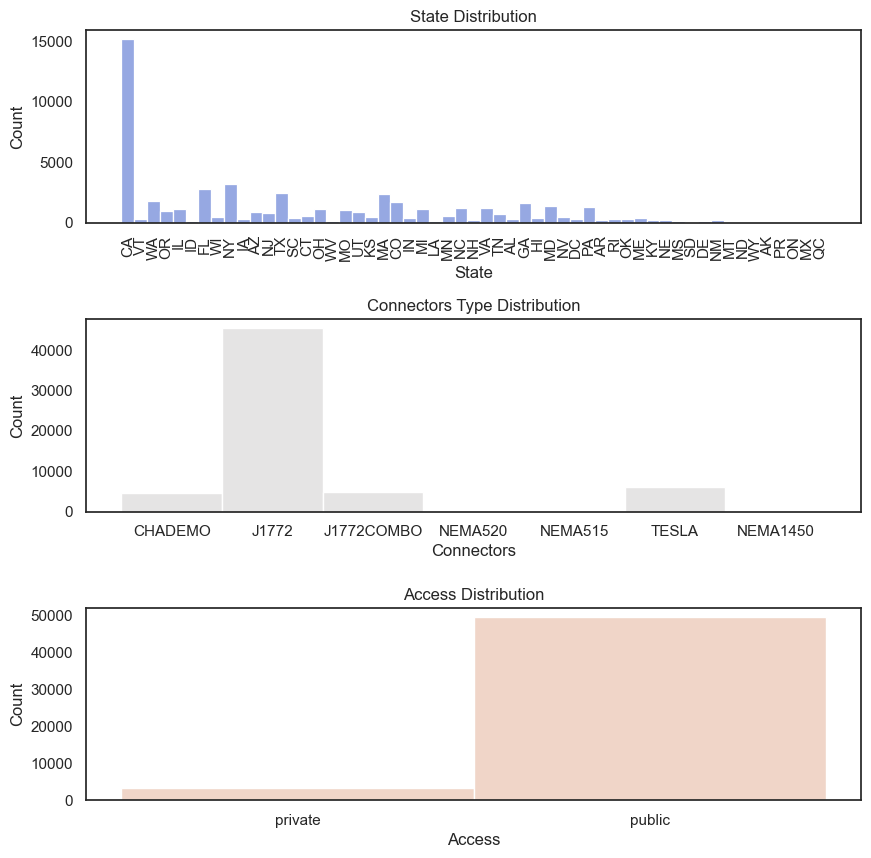

In [10]:
# Plot state, fuel_code, connectors, and access distributions
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

# State distribution
plt1 = sns.histplot(data=stations_df, x='state', ax=axes[0], color='#738bd9')
plt1.set(title='State Distribution',  xlabel='State', ylabel='Count')
plt1.tick_params(axis='x', rotation=90)

# Connectors distribution
plt2 = sns.histplot(data=connectors, ax=axes[1], color='#dddcdc')
plt2.set(title='Connectors Type Distribution',  xlabel='Connectors', ylabel='Count')

# Access distributions
plt3 = sns.histplot(data=stations_df, x='access', ax=axes[2], color='#ecc7b6')
plt3.set(title='Access Distribution',  xlabel='Access', ylabel='Count')

plt.show()

Plot 100 random recorded US stations using `folium`. Feel free to adjust the `samples` parameter, as anything larger may take a while to render. All generated `folium` html plots below are also saved in the `\outputs` directory, as they do not render on the GitHub repository.

In [11]:
# Extract dataset list of station coordinates
locations = stations_df[['latitude', 'longitude']].values

In [12]:
# Initialize folium map, centered at a kansas
samples = 100
map_stations = folium.Map(location=[38.27312, -98.5821872], zoom_start=4)

# Plot 100 random stations on US map
for i in random.sample(range(len(stations_df)), samples):
    full_address = ', '.join(stations_df[['street_address', 'city', 'state', 'zip']].iloc[i])
    public_color = '#0096FF' if stations_df['access'].iloc[i] == 'public' else '#FF5733'
    folium.Marker(locations[i], 
                  popup = f'<i>{full_address}</i>',
                  color = public_color,
                  tooltip=stations_df['name'].iloc[i]).add_to(map_stations)

map_stations.save('outputs/map_sampled_stations.html')
map_stations

Alternatively, open generated folium map [here](outputs/map_sampled_stations.html)

In [13]:
# Initialize folium heat map, centered at a kansas
heatmap_stations = folium.Map(location=[38.27312, -98.5821872], zoom_start=4)

# Plot heatmap
HeatMap(locations, min_opacity=0.2).add_to(heatmap_stations)

heatmap_stations.save('outputs/heatmap_sampled_stations.html')
heatmap_stations

Alternatively, open generated folium map [here](outputs/heatmap_sampled_stations.html)

The preliminary results from the exploratory data analysis appears to check out with the rest of the data (and that the dataset seems to be reliable and a success after wrangling. For instance, comparing the generated distribution plot and heat map of all US stations, we consistently observe that a large concentration of stations in California. The `map_stations` folium plot shows a larger distribution of publicly accessed stations (marked by blue ticks), as there is no apparent private stations (marked by red ticks) in the sampled plot. Additionally, the location data of these stations check out after manually cross referencing the addresses on the Google Maps, yielding the correct station.

### Part II: Charging Station Availability Prediction Using Clustering

For our prediction algorithm, we will be using DBSCAN clustering, a density-based spatial clustering of algorithm. We chose specifically this algorithm because it is more effective in examining large spatial datasets and the local density of the data points (than a K-NN algorithm for example). DSCAN requires two parameters, epsilon `eps` and minimum points `min_samples`. Epsilon is the radius between each data point to check the density and the minimum points specified is the number of data points required to be classified within a density cluster.

In [14]:
'''
For our first model we decided epsilon of 10km and minimum points of least 1 station needed.
Convert epsilon distance to radians. The `haversine` metric requires our epsilon parameter 
to be standardized to radians when calculating distances on the Earth.
'''

kms_per_radian = 6371.0088
epsilon = 10 / kms_per_radian
min_samples = 1

# Fit DBSCAN model with location data points
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
dbscan = dbscan.fit(np.radians(locations))

station_labels = dbscan.labels_
num_clusters = len(set(station_labels))

print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 2996


In [15]:
# Compute center points for each DBSCAN cluster
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

station_clusters = pd.Series([locations[station_labels == i] for i in range(num_clusters)])
centermost_station_points = station_clusters.map(get_centermost_point)

centermost_station_points

0                    (33.952451, -118.136794)
1                    (32.877149, -117.145881)
2       (33.7778889405388, -116.405694450182)
3                     (37.624584, -122.12718)
4                    (38.631393, -121.396604)
                        ...                  
2991     (40.9019623876525, -80.825184837049)
2992              (30.16664483, -98.38214546)
2993                      (41.0251, -77.5243)
2994    (41.1186986523134, -98.5470839753888)
2995                   (47.28245, -101.31961)
Length: 2996, dtype: object

To test our model, we will be using our validation dataset we generated from the dropped rows in the raw Electric & Alternative Fuel Charging Stations 2023 dataset. Although the validation dataset is comprised of actual charging and fueling stations, we will use them as arbitrary addresses/locations in the US to classify them with our algorithm.

Classification is performed in polynomial time; adjust validation size if classification takes too long. Default is set to 100 samples

In [16]:
location_validation_label = []

# Iterate through all test points
for _, test_station in location_validation.iterrows():
    test_station = (test_station['latitude'], test_station['longitude'])
    neareast_distance = float('inf')
    label = -1
    
    # Iterate through all center points, choose closest to classify test point
    for cluster, center_point in enumerate(centermost_station_points):
        curr_distance = distance(test_station, center_point)
        
        # Update for nearest point
        if curr_distance < neareast_distance:
            neareast_distance = curr_distance
            label = cluster
    
    # Add label
    location_validation_label.append(label)

In [17]:
# Add label column to validation df
location_validation['label'] = location_validation_label

location_validation.head()

,latitude,longitude,label
1863,35.138558,-83.926775,1434
8350,46.037004,-123.914267,746
1632,36.102931,-86.815943,95
10422,43.725738,-83.446236,2881
2459,40.942518,-98.293548,1074


In [18]:
# Classification of a random test point on folium map
test_point = location_validation.sample(1)
test_point_location = (test_point['latitude'], test_point['longitude'])
test_point_label = int(test_point['label'])

test_clusters = locations[station_labels == test_point_label]

# Initialize folium map, centered at a kansas
clustered_stations = folium.Map(location=[38.27312, -98.5821872], zoom_start=4)

# Plot center of clustered stations on US map
for station in test_clusters:
    folium.Marker(station).add_to(clustered_stations)
    
folium.Marker(test_point_location, icon=folium.Icon(color='red')).add_to(clustered_stations)

clustered_stations.save('outputs/test_cluster.html')

Alternatively, open generated folium map [here](outputs/test_cluster.html)

### Part III: Validation Metrics of Base Clustering Model

Our evaluation metric is quantified by the maximum distance in kilometers between a test point/location and the furthest boundary point/station within its cluster. This is presumably the longest one-trip distance a driver can plan if they are within their respective DBSCAN cluster or, in better words, within a safe range of charging stations (based on `epsilon`).

In [19]:
# Get furthest distance between test location and boundary point within their cluster
station_clusters = pd.Series([locations[station_labels == i] for i in range(num_clusters)])
distance_metric = []

# Iterate through all test points to get distance metric
for _, test_station in location_validation.iterrows():
    test_location = (test_station['latitude'], test_station['longitude'])
    label = int(test_station['label'])
    max_distance = 0
    
    # Iterate through all stations, compare for largest distance metric
    for station in station_clusters[label]:
        station = (station[0], station[1])
        curr_distance = distance(station, test_location)
    
        # Swap
        if curr_distance > max_distance:
            max_distance = curr_distance
    
    # Append metric for one label iteration
    distance_metric.append(max_distance.km)

In [20]:
# Add metric column to validation dataframe
location_validation['distance_metric'] = distance_metric

location_validation.head()

,latitude,longitude,label,distance_metric
1863,35.138558,-83.926775,1434,6.696921
8350,46.037004,-123.914267,746,18.385019
1632,36.102931,-86.815943,95,31.028907
10422,43.725738,-83.446236,2881,18.198592
2459,40.942518,-98.293548,1074,15.768796


Our model performance metric will be judged by averaging all maximum distance metrics for all test points/locations. To interpret this performance metric, it is the expected road trip distance a driver can last as long as they are within an `epsilon` proximity of charging stations.

In [21]:
# Model performance metric
base_performance = location_validation['distance_metric'].mean()
base_performance

34.00601258262306

### Part IV: Model Selection (Varying `epsilon` Distance)

To improve our base DBSCAN model, we will perform model selection by examining the performance trend for different `epsilon` hyperparameter values. What we will expect is an elbow curve for larger `epsilon` values, and ideally we would likely to choose the `epsilon` optimum at the "elbow" point. This represents the optimum `epsilon` hyperparameter because the model doesnt get signficantly any better above this point.

For model selection, we will observe `epsilon` values up to 200 (km.), as prior experimentation observed that the model performance doesnt significantly improve any further. For another interpretation, an `epsilon` distance of 200 (km.) is about half the average mileage of an EVs.

**NOTE**: Recommend skipping below cell and loading pickled `model_performances` to generate elbow plot

In [22]:
from utils.dbscan_metric import DBSCANUtil

if NEW_MODEL_SELECTION:

    # Perform model selection for different epilon values, recommend skipping loading pickle from last run
    epsilons = [5, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
    model_performances = {10: base_performance}
    for epsilon in epsilons:
        test = DBSCANUtil(stations_df, location_validation, epsilon)
        performance = test.output_performance()
        model_performances.update({epsilon: performance})

    # Save output as pickle
    pickle.dump(model_performances, open('outputs/model_performances.p', 'wb'))

In [23]:
# Load output
model_performances = pickle.load(open('outputs/model_performances.p', 'rb'))

From the elbow curve, we see that aproximately an `epsilon` value of 75 (km.) is the most optimal for our DBSCAN clustering model.

[Text(0.5, 1.0, 'Elbow Curve for Various DBSCAN Epsilon')]

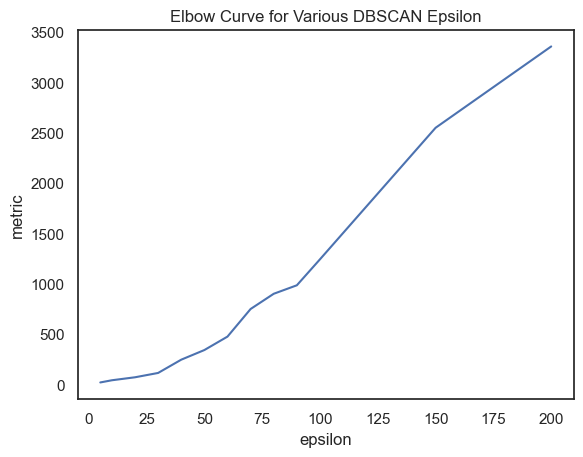

In [24]:
# Plot an elbow curve to select the best epsilon hyperparameter
model_performances = pd.DataFrame(list(zip(model_performances.keys(), model_performances.values())), 
                                  columns =['epsilon', 'metric'])
model_performances = model_performances.sort_values('epsilon')

sns.lineplot(data=model_performances, 
             x='epsilon', 
             y='metric', 
             linewidth = 1.5).set(title='Elbow Curve for Various DBSCAN Epsilon')

In [25]:
# Tweak optimal epsilon based on elbow curve if needed
optimal_epsilon = 75

# Model performance on optimal epsilon
test = DBSCANUtil(stations_df, location_validation, optimal_epsilon)
test.output_performance()

798.2481881272333

### Part V: Variability of Clustering Model for Different Variables

We can observe the effects of our base model by isolating for different variables in our dataset, specifically for `level1` chargers, `level2` chargers, `dc` chargers, public `access`, and port `connectors`. We will first transform our cleaned dataset into a one-hot encoded dataset for these variables and perform DBSCAN clustering again with the optimal `epsilon` value we found previously. 

In [26]:
# One hot encode charger
stations_df['level1_count'] = np.where(stations_df['level1_count'] > 0, 1, 0)
stations_df['level2_count'] = np.where(stations_df['level2_count'] > 0, 1, 0)
stations_df['dc_count'] = np.where(stations_df['dc_count'] > 0, 1, 0)

# One hot encode connectors. Cast connectors column into list
stations_df['connectors'] = stations_df['connectors'].str.split()
stations_df = stations_df.join(pd.crosstab((s:=stations_df['connectors'].explode()).index, s))
stations_df.rename(columns={'level1_count': 'level1', 
                            'level2_count': 'level2',
                            'dc_count': 'dc'}, inplace=True)

# One hot encode access
stations_df['access'] = np.where(stations_df['access'] == 'public', 1, 0)

stations_df = stations_df.drop(columns=['connectors'])
stations_df.head()

,name,street_address,city,state,zip,latitude,longitude,level1,level2,dc,access,CHADEMO,J1772,J1772COMBO,NEMA1450,NEMA515,NEMA520,TESLA
0,LADWP - Truesdale Center,11797 Truesdale St,Sun Valley,CA,91352,34.248319,-118.387971,0,1,1,0,1,1,1,0,0,0,0
1,LADWP - West LA District Office,1394 S Sepulveda Blvd,Los Angeles,CA,90024,34.052542,-118.448504,0,1,0,0,0,1,0,0,0,0,0
2,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,34.040539,-118.271387,0,1,0,1,0,1,0,0,0,0,0
3,LADWP - John Ferraro Building,111 N Hope St,Los Angeles,CA,90012,34.059133,-118.248589,0,1,1,0,1,1,1,0,0,0,0
4,LADWP - Haynes Power Plant,6801 E 2nd St,Long Beach,CA,90803,33.759802,-118.096665,0,1,1,0,1,1,1,0,0,0,0


In [27]:
# Fit model for different variable availabilities. 
# Tweak optimal epsilon based on elbow curve if needed
var_validation = location_validation.sample(n=50)
variables = ['level1', 
             'level2', 
             'dc', 
             'access', 
             'CHADEMO', 
             'J1772', 
             'J1772COMBO', 
             'NEMA1450', 
             'NEMA515',
             'NEMA520',
             'TESLA']

# Get metric for different variable availabilities
for variable in variables:
    
    # Perform DBSCAN with new training set specific for variable
    var_training = stations_df[stations_df[variable] == 1]
    test = DBSCANUtil(var_training, var_validation, optimal_epsilon)
    test_performance = test.output_performance()
    
    print(f'Metric for stations with {variable}: {test_performance}')

Metric for stations with level1: 112.34176014916186
Metric for stations with level2: 780.2692053707393
Metric for stations with dc: 405.8386663667763
Metric for stations with access: 793.908556972861
Metric for stations with CHADEMO: 213.9056817025092
Metric for stations with J1772: 773.3642693673629
Metric for stations with J1772COMBO: 221.24156261995603
Metric for stations with NEMA1450: 477.5222904133658
Metric for stations with NEMA515: 177.26645650539882
Metric for stations with NEMA520: 136.64169780721585
Metric for stations with TESLA: 498.0112934559011


# Discussion

### Interpreting the result

Likely the best position to be as an EV driver would be a California resident with a `J1772` type EV port. Based on our exploratory data analysis, we observed the distributions for California stations and stations with `J1772` type EV ports to be signficantly large.

For the general availability for charging stations, we found that on average a single road-trip (with no stops) a driver can last is about 837.925 (km.). This is assuming that the driver is within a safe range of charging stations, based on `optimal_epsilon` of 75 (km.). In other words, a driver can confidently drive the distance from UCSD to San Francisco given that there is a sufficient cluster of charging stations within a 75 (km.) distance.

Although not explicitly shown in a cell (rather done from experimentation), the model performance for `epsilon` values greater than 200 (km.) do not significantly change when performing model selection. We could interpret this as how driving more than 200 (km.) is not frequent in day-to-day road trips or an apparent seperation from station clusters (ex. boarders between states).

By examining the variability of our optimized DBSCAN model, we saw that specific charger, access, and port types, can affect the availability of charging stations. By examining the distance metrics for `level1` chargers, `level2` chargers, `dc` chargers, `public` access, and different port `connectors`, we see that stations with `level1` ports for instance are sparse. Meanwhile, stations with `public` access are significantly dense and widely found in the US.


### Limitations

Some limitations or biases of our selected dataset is that it is exclusive to the population of United States. Therefore, our findings may not generalize to all EV drivers and road trip plannings. In fact, our findings is expected to not reflect for all EV drivers and road trip plannings for long, as the US continues to develop infrastructure and more EV and alternative fueling stations. The dataset we employed for our project continually updates on Kaggle, and we deliberately dropped null containing observations (which could have potentially improved our model fit) despite them being confirmed as EV stations in the US.

One major bias accounted in our project was calculating our distance metric. The distance metric we obtained and observed for our models represented the longest one-trip distance a driver can plan if they are within a safe range of charging stations (based on `epsilon`). We obtained this distance metric by calculating the Haversine distance between an arbitrary test location point and the furthest boundary point/station within the test point's cluster. However, these distance metrics represent the immediate distance between the points, not the road distance. A possible solution to this bias would be using a mapping API to provide us the road distance between two location points (accounting for paths, streets, freeways, etc.).

Another set of bias is how drivers have other confoundings specs for their EV, such as make, mileage, cost, etc., that may not agree with the results from our model findings.

### Ethics & Privacy

Our project uses a dataset pertaining to all charging stations in the United States and their vehicle class, station name, location details, schedules, EV-connector types, etc as of 2023. Our dataset was found on Kaggle, a specialized Data Science community that caters to publishing as public datasets, but was orginally published by the National Renewable Energy Laboratory. A potential privacy concern could be how some stations in datset were either labeled as `public` or `private`. It may appropriate to resign private stations from our road planning model, as they are likely reserved for businesses or proprietary-use than for the general public.

One major ethic pertaining to the results of our project is that it is impractical to fully rely on for actual road trip plannings. There are better road trip planning systems, such as Google Maps, that likely provide better a solution. The goal of this project is to provide a prediction metric for road plannings based on location and to enhance confidence when driving an EV from observing the availability of charging stations.

### Conclusion

For the general availability for charging stations, we found that on average a single road-trip (with no stops) a driver can last is about 837.925 (km.). This is assuming that the driver is within a safe range of charging stations, based on `optimal_epsilon` of 75 (km.). We found this distance metric by employing a DBSCAN algorithm with a recent training datset on all charging stations in the United States as of 2023 and averaging the Haversine distance between an test location points and the furthest boundary point/station within the test point's cluster. Altough this availability metric may alter based on factors, such as being a California resident or an owner of a `J1772` type EV port, as this greatly increases availability of charging stations. Meanwhile, factors like the need for `level1` chargers are harsh on the availability of stations. The model implemented may not be the most practical tool for actual road trip planning, but it does provide insight for those who are hesitant on using/buying EVs.

# Footnotes

<a name="garling"></a>1.[^](#garlingnote): Gärling and Thøgersen (1 January 2001) 
Marketing of electric vehicles. https://onlinelibrary.wiley.com/doi/abs/10.1002/1099-0836(200101/02)10:1%3C53::AID-BSE270%3E3.0.CO;2-E?casa_token=_RWO6TVTsRYAAAAA:VnD9Pwogm8DFhk4PyXZYdFFZtxNb7t-CXYrPfmWHlr5zYd4aKK8HOB_SnysEVD1p5_K0TLTlOCak83o<br>

<a name="dominguez"></a>2.[^](#domingueznote): Aguilar-Dominguez, Donovan (February 2021) 
Machine learning approach for electric vehicle availability forecast to provide vehicle-to-home services. https://www.sciencedirect.com/science/article/pii/S2352484721001517<br>

<a name="ullah"></a>3.[^](#ullah): Ullah, et. al (April 2023) 
Modeling of machine learning with SHAP approach for electric vehicle charging station choice behavior prediction. https://www.sciencedirect.com/science/article/abs/pii/S2214367X22001326<br>